# Canadian Parliament data

In this notebook, we use the data from the 36th and 39th parliament from [Hirst et al.](ftp://learning.cs.toronto.edu/dist/gh/Hirst-etal-2010-JADT.pdf) and focus on building a robust classifier using the backdoor adjustment method.

For more details concerning the different parliaments, see the [List of Canadian federal parliaments](http://en.wikipedia.org/wiki/List_of_Canadian_federal_parliaments).

## Imports

In [2]:
import glob
import sys
import re
from collections import defaultdict
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import pearsonr, sem

import seaborn as sns
sns.set_context('paper')
sns.set_style('whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
import os
import sys
from collections import Counter, defaultdict
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import adaptive_confound.control as acc
import adaptive_confound.utils as acu
import adaptive_confound.topic_model as actm
import adaptive_confound.confound_detection as accd

Using TensorFlow backend.
/home/virgile/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load data

In [4]:
def lazy_file_load(dir_path, file_regex, n=None, encoding='utf-8'):
    file_path_list = sorted(glob.glob(dir_path + file_regex))
    l = len(file_path_list)
    _n = l if n == None or n > l else n
    num = 0
    while num < _n:
        with open(file_path_list[num], encoding=encoding) as fd:
            c = fd.read()
            yield c
            num += 1
            
party_translation = {
    'Ref':'Conservative', 'PC':'Conservative', 'CPC':'Conservative',
    'Lib': 'Liberal'
}
#     'Ignore': ['BQ', 'NDP', 'NPD', 'Canadian Nuclear Safety Commission',
#                'Directorate of Nuclear Cycle and Facilities Regulation',
#                'Ind. Cons', 'Bloc Quebecois', 'Ind']

def hansard_txt(dir_path='/data/1/virgile/hansard/36/', lang='e', n=None, ignore_alt_parties=True):
    regex_speaker = re.compile(r'(Mr\.|Mrs\.|Ms\.|Hon\.|The)([^\(:]*)(\((.+),(.+)\))?:$')
    regex_topic = re.compile(r'^([A-Z]{2,} +)+$')
    regex_comment = re.compile(r'^\([^\(]{4,}\)')

    name2party = defaultdict(set)
    party2names = defaultdict(set)
    content = defaultdict(list)

    topics = []
    for i, h in tqdm(enumerate(lazy_file_load(dir_path, '/*'+lang, n, "ISO-8859-1"))):
        h = h.split('HOUSE OF COMMONS')[1] # remove header
        lines = h.split('\n') # split on linefeed
        match_comment_idx = set([i for i, l in enumerate(lines) if regex_comment.match(l)])
        match_topic_idx = set([i for i, l in enumerate(lines) if regex_topic.match(l)])
        # remove comments, topics, and topic separations characters
        cond_del = lambda i: i in match_comment_idx or i in match_topic_idx or lines[i].strip() == '* * *'
        new_lines = [l for i,l in enumerate(lines) if not cond_del(i)]
        lines = new_lines
        match_speaker_tuples = [(i, regex_speaker.match(l)) for i, l in enumerate(lines) if regex_speaker.match(l)]
        for j, m in enumerate(match_speaker_tuples):
            prefix = m[1].group(1).strip()
            name = m[1].group(2).strip()
            n = ' '.join([prefix, name])
            if j+1 < len(match_speaker_tuples): # there is a next element
                next_m = match_speaker_tuples[j+1]
                content[n].extend(lines[m[0]+1:next_m[0]])
            else:
                content[n].extend(lines[m[0]+1:])
            if m[1].group(5) is not None:
                p = m[1].group(5).strip().strip('.')
                p = party_translation.get(p, 'Ignore')
                if not ignore_alt_parties or p != 'Ignore':
                    party2names[p].add(n)
                    name2party[n].add(p)
                else:
                    del content[n]
    return name2party, party2names, content        
    
def hansard_xml(dir_path, n=None,  ignore_alt_parties=True):
    regex_speaker = re.compile(r'(Mr\.|Mrs\.|Ms\.|Hon\.)([^\(]+)\((.+),(.+)\)')
    
    name2party = defaultdict(set)
    party2names = defaultdict(set)
    content = defaultdict(list)
    
    for i, h in tqdm(enumerate(lazy_file_load(dir_path, '/*', n))):
        soup = BeautifulSoup(h, 'lxml')
        interventions = soup.find_all('intervention', type='Debate')
        for intervention in interventions:
            title = intervention.personspeaking.affiliation.string
            if title:
                m = regex_speaker.match(title)
                if m:
                    prefix = m.group(1).strip()
                    name = m.group(2).strip()
                    n = ' '.join([prefix, name])
                    p = m.group(4).strip().strip('.')
                    p = party_translation.get(p, 'Ignore')
                    c = [p.get_text().strip() for p in intervention.content('paratext')]
                    if not ignore_alt_parties or p != 'Ignore':
                        name2party[n].add(p)
                        party2names[p].add(n)
                        content[n].extend(c)
    # remove politicians with ambiguous labels
    ambiguous_politicians = [k for k, v in name2party.items() if len(v) > 1]
    for pol in ambiguous_politicians:
        del name2party[pol]
        for _, names in party2names.items():
            names.discard(pol)
        del content[pol]
    return name2party, party2names, content

def parliament_stats(n2p, p2n):
    print('%d politicians, %d political parties.' % (len(n2p), len(p2n)))
    parties = sorted(list(p2n.keys()))
    for p in parties:
        print("- %s:\t%d politicians" % (p, len(p2n[p])))

In [5]:
n2p = {}
p2n = {}
content = {}
n2p[36], p2n[36], content[36] = hansard_txt("/data/virgile/hansard/36")
n2p[39], p2n[39], content[39] = hansard_xml('/data/virgile/hansard/39/')
n2p[40], p2n[40], content[40] = hansard_xml('/data/virgile/hansard/40/')

313it [00:04, 73.92it/s]
16it [00:03,  3.88it/s]


KeyboardInterrupt: 

In [12]:
parl_nums = [36,39,40]
for pn in parl_nums:
    print('= Parliament %d:' % pn)
    print('================')
    parliament_stats(n2p[pn], p2n[pn])

= Parliament 36:
257 politicians, 2 political parties.
- Conservative:	80 politicians
- Liberal:	177 politicians
= Parliament 39:
239 politicians, 2 political parties.
- Conservative:	135 politicians
- Liberal:	104 politicians
= Parliament 40:
237 politicians, 2 political parties.
- Conservative:	158 politicians
- Liberal:	79 politicians


## Experiment

### Generate matrices

In [21]:
def vectorize_speeches(p2n, content, pns=[36,39,40], parties=['Liberal', 'Conservative']):
    vec = TfidfVectorizer(min_df=5, max_df=.8, stop_words='english', max_features=15000)
    
    le = preprocessing.LabelEncoder()
    le.fit(parties)
    
    governing = {
        36: 'Liberal',
        39: 'Conservative',
        40: 'Conservative'
    }
    
    def get_all_speeches():
        for pn in pns:
            for party in parties:
                for n in p2n[pn][party]:
                    yield ' '.join(content[pn][n])
                    
    def get_labels():
        all_Y = []
        all_C = []
        indices = {}
        idx = 0
        for pn in pns:
            indices[pn] = [idx]
            for party in parties:
                l = len(p2n[pn][party])
                idx += l
                all_Y.extend(le.transform([party]*l))
                c = 1 if party == governing[pn] else 0
                all_C.extend([c]*l)
            indices[pn].append(idx)
        return np.array(all_Y), np.array(all_C), indices
    
    all_X = vec.fit_transform(get_all_speeches())
    all_Y, all_C, indices = get_labels()

    X = {}
    Y = {}
    C = {}
    
    for pn, (start, end) in indices.items():
        X[pn] = all_X[start:end]
        Y[pn] = all_Y[start:end]
        C[pn] = all_C[start:end]
    return X, Y, C, np.array(vec.get_feature_names())

In [22]:
X, Y, C, feature_names = vectorize_speeches(p2n, content)

In [23]:
X

{36: <257x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 633368 stored elements in Compressed Sparse Row format>,
 39: <239x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 546534 stored elements in Compressed Sparse Row format>,
 40: <237x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 508074 stored elements in Compressed Sparse Row format>}

In [24]:
import scipy.sparse as sp

In [29]:
Cs = np.hstack([C[_] for _ in [36,39,40]])

In [40]:
ds = {}
for n in [36,39,40]:
    ds[n] = acu.Dataset(X=X[n], y=Y[n], z=C[n], features=feature_names)
    ds[n].to_pickle("/data/virgile/confound/adaptive/in/canparliament_{}.pkl".format(n))

In [34]:
d

< Dataset: size=733, p(y)=0.49, p(z)=0.64, bias=0.38, parent=None >

In [35]:
d.to_pickle("/data/virgile/confound/adaptive/in/canparliament.pkl")

In [37]:
d2 = d.make_balanced_dataset()
d2.to_pickle("/data/virgile/confound/adaptive/in/balanced_canparliament.pkl")

In [38]:
d2

< Dataset: size=320, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=733, p(y)=0.49, p(z)=0.64, bias=0.38, parent=None > >

In [6]:
ds = {}
for n in [36,39,40]:
    ds[n] = acu.read_pickle("/data/virgile/confound/adaptive/in/canparliament_{}.pkl".format(n))

### Classifier Models

In [8]:
# %run models.py
# %run ba.py
# %run ba_c_study.py
backdoor_adjustment_var_C = lambda x,y,z,t,u,c: acc.BackdoorAdjustment(transform=lambda _: _*c).fit(x,z.reshape(-1,1),y)
backdoor_adjustment = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,1)
backdoor_adjustment_Z5 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,5)
backdoor_adjustment_Z10 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,10)
backdoor_adjustment_Z100 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,100)
backdoor_adjustment_Z1000 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,1000)

In [12]:
import numpy as np
import scipy.sparse as sparse
import copy

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2
from sklearn.preprocessing import scale
from scipy import sparse

def scale_X(X):
    X = X.astype(float)
    if issparse(X):
        X = scale(X, with_mean=False)
    else:
        X = scale(X)
    return X

# Basic Models
def lr(X, y, c, rand, feature_names):
    clf = LogisticRegression(class_weight='balanced')
    #X = scale_X(X)
    clf.fit(X, y)
    return clf

def lin_svc(X, y, c, rand, feature_names):
    clf = LinearSVC()
    clf.fit(X,y)
    return clf

def nb(X, y, c, rand, feature_names):
    clf = BernoulliNB()
    #X = scale_X(X)
    clf.fit(X, y)
    return clf

# A matching-based classifier.
def make_same_length(a, b):
    # Duplicate the smaller list until it is at least as large as the larger list.
    if len(a) < len(b):
        factor = int(math.ceil(1. * len(b) / len(a)))
        a = a * factor
    else:
        factor = int(math.ceil(1. * len(a) / len(b)))
        b = b * factor
    return a, b        

    
def matching_sum(X, y, c, rand, feature_names):
    """
    For each training example where y=y_i and c=c_i, create a negative example equal to the mean
    feature value for y=y_i' and c=c_i.
    Training objective is to discriminate these pairs of examples.
    FIXME: this is slow.
    """
    yc_eq = set(np.where(y == c)[0])
    yc_diff = set(np.where(y != c)[0])
    ypos = set(np.where(y == 1)[0])
    yneg = set(np.where(y == 0)[0])
    
    both_pos = list(yc_eq & ypos)
    both_neg = list(yc_eq & yneg)
    ypos_cneg =list(yc_diff & ypos)
    yneg_cpos =list(yc_diff & yneg)
    
    both_pos_sum = X[both_pos, :].mean(axis=1)
    both_neg_sum = X[both_neg, :].mean(axis=1)
    ypos_cneg_sum = X[ypos_cneg, :].mean(axis=1)
    yneg_cpos_sum = X[yneg_cpos, :].mean(axis=1)

    #X = scale_X(X)
    rows = []
    newY = []
    flip = 1.
    for i in range(len(y)):
        if y[i] == 1:
            if c[i] == 1:
                rows.append((X[i] - yneg_cpos_sum) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1
                #for j in yneg_cpos:
                #    if j > i:
                #        rows.append((X[i] - X[j]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
            else:
                rows.append((X[i] - both_neg_sum) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                
                #for j in both_neg:
                #    if j > i:
                #        rows.append((X[i] - X[j]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
        else:
            if c[i] == 1:
                rows.append((ypos_cneg_sum - X[i]) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                
                #for j in ypos_cneg:
                #    if j > i:
                #        rows.append((X[j] - X[i]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
            else:
                rows.append((both_pos_sum - X[i]) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                                
                #for j in both_pos:
                #    if j > i:
                #        rows.append((X[j] - X[i]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
                    
    newX = sparse.vstack(rows)
    m = LogisticRegression(fit_intercept=False, class_weight="balanced")
    print('fit on %d instances' % newX.shape[0])
    m.fit(newX, newY)
    return m                

# problem when dataset does not contain instances for all y-c pairs.
def matching(X, y, c, rand, feature_names):
    """
    For each training example where y=y_i and c=c_i, create a negative example by sampling 
    an instance where y!=y_i and c=c_i
    Training objective is to discriminate these pairs of examples.
    FIXME: accuracy is pretty low. Is it because p(c) is biases in the sampling method?
    """
    yc_eq = set(np.where(y == c)[0])
    yc_diff = set(np.where(y != c)[0])
    ypos = set(np.where(y == 1)[0])
    yneg = set(np.where(y == 0)[0])
    
    both_pos = list(yc_eq & ypos)
    both_neg = list(yc_eq & yneg)
    ypos_cneg =list(yc_diff & ypos)
    yneg_cpos =list(yc_diff & yneg)

    rows = []
    newY = []
    flip = 1.
    for i in range(len(y)):
        if y[i] == 1:
            if c[i] == 1:
                fv = X[i] - X[rand.choice(yneg_cpos)]
            else:
                fv = X[i] - X[rand.choice(both_neg)]
        else:
            if c[i] == 1:
                fv = X[rand.choice(ypos_cneg)] - X[i]
            else:
                fv = X[rand.choice(both_pos)] - X[i]
            
        rows.append(fv * flip)
        newY.append(max(int(flip), 0))
        flip *= -1
                    
    newX = sparse.vstack(rows)
    m = LogisticRegression(fit_intercept=False, class_weight="balanced")
    m.fit(newX, newY)
    return m    

# Sum out the confounding variable.
# 1. Fit classifier in product space of c/y. (E.g., P(c^y|x))
# 2. To classify new x, return P(c=1^y=1|x) + P(c=0^y=1|x)
class SumOutClf:
    def __init__(self, clf):
        self.clf = clf
        self.coef_ = [self.clf.coef_[2]]
        
    def predict(self, X):
        proba = np.matrix(self.clf.predict_proba(X))
        # sum cols 1,2 (y0c0, y0c1) and cols 3,4 (y1c0,y1c1)
        proba = np.hstack((proba[:,:2].sum(axis=1), proba[:,2:4].sum(axis=1)))
        # return argmax of each row
        return np.array(proba.argmax(axis=1).T.tolist()[0])
        
# problem on sumout when not all pairs y/c are present in the data
def sumout(X, y, c, rand, feature_names):
    clf = LogisticRegression(class_weight="balanced")
    label2index = {(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3}
    yc = [label2index[(yi, ci)] for yi, ci in zip(y, c)]
    clf.fit(X, yc)
    return SumOutClf(clf)

def get_n_top_features(X, c, n, feature_names):
    chi, F = chi2(X, c)
    clf = LogisticRegression(class_weight="balanced")
    clf.fit(X, c)
    coef_sign = clf.coef_[0] / np.abs(clf.coef_[0])
    signed_chi = chi * coef_sign
    counts = X.sum(0).tolist()[0]
    top_feats = [i for i in np.argsort(signed_chi)[::-1] if counts[i] > 1][:n]
    if feature_names is not None:
        print('top_feats=', feature_names[top_feats])
    return top_feats

def feature_select(X, y, c, rand, feature_names):
    """ Find the highest chi2 feature for class c and remove it from the classifier."""
    #X = scale_X(X)
    chi, F = chi2(X, c)
    clf = LogisticRegression(class_weight="balanced")
    clf.fit(X, c)
    coef_sign = clf.coef_[0] / np.abs(clf.coef_[0])
    signed_chi = chi * coef_sign
    counts = X.sum(0).tolist()[0]
    top_feats = [i for i in np.argsort(signed_chi)[::-1] if counts[i] > 1][:1]
    if feature_names is not None:
        print('top_feats=', feature_names[top_feats])
    X2 = copy.copy(X)
    X2[:,top_feats] = 0.  # Set top feature to 0
    clf.fit(X2, y)
    return clf

def lr_subsampling(X, y, c, rand, feature_names):
    """
    Subsampling LR for binary label and binary confounder.
    """
    #X = scale_X(X)
    yc_eq = set(np.where(y == c)[0])
    yc_diff = set(np.where(y != c)[0])
    ypos = set(np.where(y == 1)[0])
    yneg = set(np.where(y == 0)[0])
    
    both_pos = list(yc_eq & ypos)
    both_neg = list(yc_eq & yneg)
    ypos_cneg =list(yc_diff & ypos)
    yneg_cpos =list(yc_diff & yneg)

    all_classes = [both_pos, both_neg, ypos_cneg, yneg_cpos]
    min_class = min([len(l) for l in all_classes if l])

    subsampled_idx = []
    for l in all_classes:
        if l:
            subsampled_class = np.random.choice(l, min_class, replace=False)
            subsampled_idx.extend(subsampled_class)

    yc_eq = set(np.where(y[subsampled_idx] == c[subsampled_idx])[0])
    yc_diff = set(np.where(y[subsampled_idx] != c[subsampled_idx])[0])
    ypos = set(np.where(y[subsampled_idx] == 1)[0])
    yneg = set(np.where(y[subsampled_idx] == 0)[0])
    
    both_pos = list(yc_eq & ypos)
    both_neg = list(yc_eq & yneg)
    ypos_cneg =list(yc_diff & ypos)
    yneg_cpos =list(yc_diff & yneg)

    all_classes = [both_pos, both_neg, ypos_cneg, yneg_cpos]
    #print([len(x) for x in all_classes])
    
    return lr(X[subsampled_idx],
              y[subsampled_idx],
              c[subsampled_idx], rand, feature_names)

class BackdoorAdjustment:      
    def __init__(self, c_ft_value=1.):
        self.clf = LogisticRegression(class_weight='balanced')                                           
        self.c_ft_value = c_ft_value
    
    def predict_proba(self, X):                                               
        # build features with every possible confounder                       
        l = X.shape[0]                                                        
        rows = range(l*self.count_c)                                                     
        cols = list(range(self.count_c))*l 
        data = [self.c_ft_value]*(l*self.count_c)
        c = sparse.csr_matrix((data, (rows, cols)))
        # build the probabilities to be multiplied by
        p = np.array(self.c_prob).reshape(-1,1)
        p = np.tile(p, (X.shape[0], 1))                                       
                                                                            
        # combine the original features and the possible confounder values    
        repeat_indices = np.arange(X.shape[0]).repeat(self.count_c)                      
        X = X[repeat_indices]      
        Xc = sparse.hstack((X,c)) 
        proba = self.clf.predict_proba(Xc)
        # multiply by P(z) and sum over the confounder for every instance in X
        proba *= p
        proba = proba.reshape(-1, self.count_c, self.count_y)
        proba = np.sum(proba, axis=1) 
        # normalize   
        norm = np.sum(proba, axis=1).reshape(-1,1)
        proba /= norm
        return proba                                                          
                                                                              
    def predict(self, X):                                                     
        proba = self.predict_proba(X)                                         
        return np.array(proba.argmax(axis=1))                                 
          
    def fit(self, X, y, c):
        self.c_prob = np.bincount(c)/len(c) 
        self.count_c = len(set(c))
        self.count_y = len(set(y))

        rows = range(len(c))
        cols = c
        data = [self.c_ft_value]*len(c)
        
        c_fts = sparse.csr_matrix((data, (rows, cols)))
        Xc = sparse.hstack((X, c_fts))
                                     
        self.clf.fit(Xc, y)
        self.coef_ = self.clf.coef_



### Fit on a parliament, predict on another one

In this experiment, we consider three different Canadian parliaments:

   - the 36th where the government is liberal and the opposition is conservative;
   - the 39th and 40th where the governments are conservative and the oppositions are liberal.

We show that when the governing party and the opposition party are swapped between the training and the testing data, then we have a substantial decrease in the prediction accuracy.

In [23]:
def fit_pred(clf_model, ds, p_fit, p_pred):
    # fit on p_fit
    clf = clf_model(ds[p_fit].X, ds[p_fit].y, ds[p_fit].z, None, None)
    # predict on p_pred
    Y_pred = clf.predict(ds[p_pred].X)
    # compute baseline
    counts = [np.sum(1-ds[p_pred].y), np.sum(ds[p_pred].y)]
    max_idx = np.argmax(counts)
    baseline = 1.*counts[max_idx]/np.sum(counts)
    # compute metrics
    acc = metrics.accuracy_score(ds[p_pred].y, Y_pred)
    return baseline, acc
#     print("\t- baseline = %.4f\n\t- acc = %.4f\n\t- f1 = %.4f" % (baseline, acc, f1))

In [24]:
def plot_matrix(mat, title, labels_x=None, labels_y=None, vmin=None, vmax=None, figsize=None, xlabel='Predict', ylabel='Fit'):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(mat, vmin=vmin, vmax=vmax)
    plt.title(title)
    fig.colorbar(cax)
    if labels_x:
        ax.set_xticks(np.arange(len(labels_x)))
        ax.set_xticklabels(labels_x)
    if labels_y:
        ax.set_yticks(np.arange(len(labels_y)))
        ax.set_yticklabels(labels_y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for y in range(mat.shape[0]):
        for x in range(mat.shape[1]):
            if mat[y,x] != 0:
                plt.text(x, y, '%.4f' % mat[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontweight='bold')
    plt.show()
    

def cross_parliement_accuracy(clf_model, ds, parl_number=None):
    if parl_number is None:
        parl_number = [36,39,40]
    accuracy_matrix = np.ones((len(parl_number), len(parl_number)))
    baseline_matrix = np.ones((len(parl_number), len(parl_number)))

    for i, p_fit in enumerate(parl_number):
        for j, p_pred in enumerate(parl_number):
            base, acc = fit_pred(clf_model, ds, p_fit, p_pred)
            accuracy_matrix[i,j] = acc
            baseline_matrix[i,j] = base

    return accuracy_matrix

LR - avg accuracy = 0.663


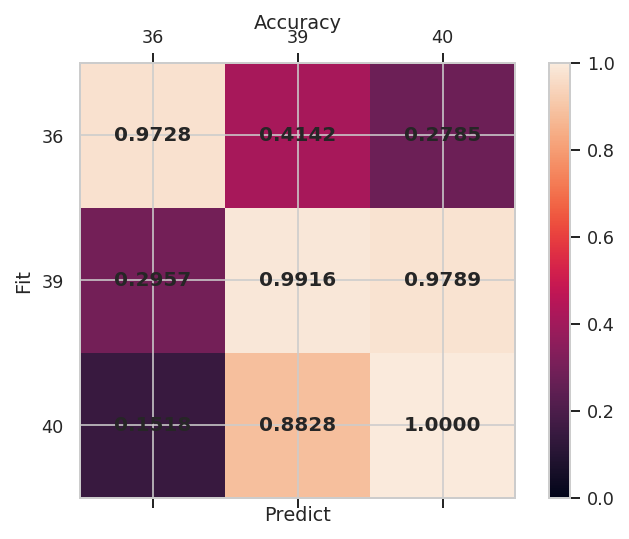

BA - avg accuracy = 0.505


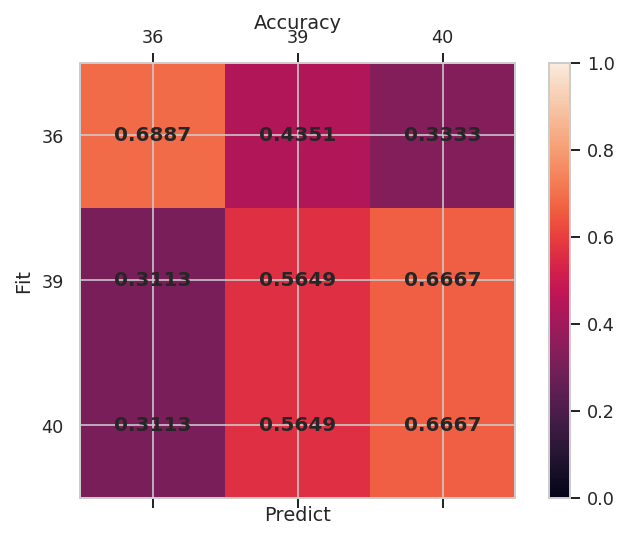

BAZ10 - avg accuracy = 0.505


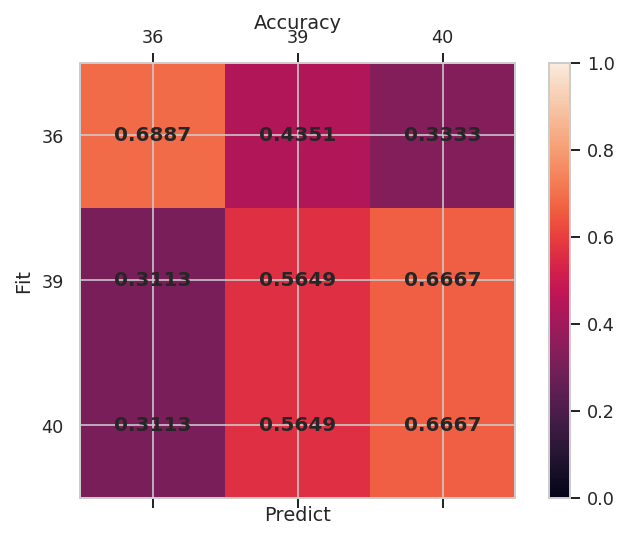

In [26]:
models = [('LR', lr), ('BA', backdoor_adjustment), ('BAZ10', backdoor_adjustment_Z10)]
parl_nums = [36,39,40]
for name, model in models:
    accuracy_matrix = cross_parliement_accuracy(model, ds)
    print("%s - avg accuracy = %.3f" % (name, np.mean(accuracy_matrix)))
    plot_matrix(accuracy_matrix, "Accuracy", parl_nums, parl_nums, vmin=0., vmax=1.)

### Backdoor Adjustment Experiment

In this section, we study the progress of the backdoor adjustment compared to classic methods in the following situation:

- we initially only have data from the 36th parliament to train our classifier;
- step by step, we add some data from the 39th parliament to our training data and observe the effect on accuracy.

In [52]:
from sklearn.cross_validation import KFold

def do_canadian_parliament_expt(train_parl, test_parl, models, n_folds=5, init_add=5,
                                npoints=25, score=metrics.accuracy_score, rand=None):
    X_init = ds[train_parl].X
    Y_init = ds[train_parl].y
    C_init = ds[train_parl].z
    
    X_test = ds[test_parl].X
    Y_test = ds[test_parl].y
    C_test = ds[test_parl].z

    scores = defaultdict(list)
    additional_data = []
    
    n_instances = X_test.shape[0]
    kf = KFold(n_instances, n_folds=n_folds, shuffle=True, random_state=rand)

    shuffled_kf = []
    for tr, te in kf:
        rand.shuffle(tr)
        shuffled_kf.append((tr, te))
    
    ratio = 1.*(n_folds-1)/n_folds
    max_point = int(ratio*len(kf.idxs))
    for step in np.linspace(init_add, max_point, npoints):
        trial_scores = defaultdict(list)
        step = int(step)
        print("%d additional instances" % step)
        for cvi, (tr, te) in enumerate(shuffled_kf):
            x_te = X_test[te]
            y_te = Y_test[te]
            c_te = C_test[te]
            
            x_tr = sparse.vstack([X_init, X_test[tr[:step]]])
            y_tr = np.hstack([Y_init, Y_test[tr[:step]]])
            c_tr = np.hstack([C_init, C_test[tr[:step]]])
#             print(x_tr.shape, x_te.shape)
            for name, model in models:
                clf = model(x_tr, y_tr, c_tr, rand, None)
                y_pred = clf.predict(x_te)
                acc = score(y_te, y_pred)
                trial_scores[name].append(acc)
        additional_data.append(step)
        for name, model in models:
            scores[name].append(trial_scores[name])
    return additional_data, scores

In [33]:
models = [('LR', lr), ('M', matching), ('BAZ10', backdoor_adjustment),
          ('SO', sumout), ('LRS', lr_subsampling)]#, ('BA', backdoor_adjustment)]
# models = [('LR', lr), ('BA', backdoor_adjustment), ('LRS', lr_subsampling),('BAZ10', backdoor_adjustment_Z10)]\
# models = []
rand=np.random.RandomState(111191)
additional_data, scores = do_canadian_parliament_expt(36, 39, models, rand=rand, npoints=15)

  0%|          | 0/15 [00:00<?, ?it/s]

5 additional instances


  7%|▋         | 1/15 [00:02<00:32,  2.35s/it]

18 additional instances


 13%|█▎        | 2/15 [00:04<00:30,  2.33s/it]

31 additional instances


 20%|██        | 3/15 [00:06<00:27,  2.33s/it]

44 additional instances


 27%|██▋       | 4/15 [00:09<00:25,  2.36s/it]

58 additional instances


 33%|███▎      | 5/15 [00:12<00:24,  2.44s/it]

71 additional instances


 40%|████      | 6/15 [00:14<00:22,  2.55s/it]

84 additional instances


 47%|████▋     | 7/15 [00:17<00:21,  2.65s/it]

98 additional instances


 53%|█████▎    | 8/15 [00:20<00:19,  2.78s/it]

111 additional instances


 60%|██████    | 9/15 [00:23<00:17,  2.91s/it]

124 additional instances


 67%|██████▋   | 10/15 [00:27<00:15,  3.05s/it]

137 additional instances


 73%|███████▎  | 11/15 [00:30<00:12,  3.20s/it]

151 additional instances


 80%|████████  | 12/15 [00:34<00:10,  3.35s/it]

164 additional instances


 87%|████████▋ | 13/15 [00:38<00:07,  3.51s/it]

177 additional instances


 93%|█████████▎| 14/15 [00:42<00:03,  3.67s/it]

191 additional instances


100%|██████████| 15/15 [00:46<00:00,  3.81s/it]


In [34]:
def plot_additional_data_expmt(additional_data, scores, markers, to_plot=None, xlabel=None, ylabel=None, fmt='pdf',
                               tofile=None, ncol=None):
    fig, ax = plt.subplots()
    plt.grid(True)
    models = sorted(scores.keys())
    for i, model_name in enumerate(models):
#         print(model_name)
        scores_list = scores[model_name]
        if to_plot is None or model_name in to_plot:
            mean_scores = [np.mean(x) for x in scores_list]
            yerr = [sem(x) for x in scores_list]
#             for tup in zip(additional_data, mean_scores, yerr):
#                 print(tup)
            plt.errorbar(additional_data, mean_scores, yerr=yerr, label=model_name, marker)#, fmt=markers[model_name])
    lgd = plt.legend(loc=3, mode='expand', bbox_to_anchor=(0., 1.02, 1., 0.),
                     ncol=i+1 if ncol is None else ncol, borderaxespad=0.)
    if ylabel is None:
        ylabel = params['score'].__name__
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xlim([min(additional_data)-2, max(additional_data)+2])
    
    ticks = np.linspace(min(additional_data), max(additional_data), len(additional_data))
    plt.xticks([int(t) for i, t in enumerate(ticks) if i % 2 == 0])
    # put grid behind other elements
    [line.set_zorder(3) for line in ax.lines]
    if tofile is None:
        plt.show()
    else:
        plt.savefig(tofile, format=fmt, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
%run models.py
%run ba.py
%run ba_c_study.py

In [57]:
models = [('LR', lr), ('M', matching), ('BAZ10', backdoor_adjustment),
          ('SO', sumout), ('LRS', lr_subsampling)]#, ('BA', backdoor_adjustment)]
# models = [('LR', lr), ('BA', backdoor_adjustment), ('LRS', lr_subsampling),('BAZ10', backdoor_adjustment_Z10)]\
rand=np.random.RandomState(1234)
additional_data, scores = do_canadian_parliament_expt(36, 39, models, rand=rand, npoints=15)

5 additional instances
18 additional instances
31 additional instances
44 additional instances
58 additional instances
71 additional instances
84 additional instances
98 additional instances
111 additional instances
124 additional instances
137 additional instances
151 additional instances
164 additional instances
177 additional instances
191 additional instances


In [54]:
markers = ['o', 's', 'v', 'x', 'd', '*']
linestyles = ['-', '-.', ':', '--', '-', '-.']
sns.set(context="paper", style="whitegrid", palette="deep", font_scale=1.5)

import pandas as pd


/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


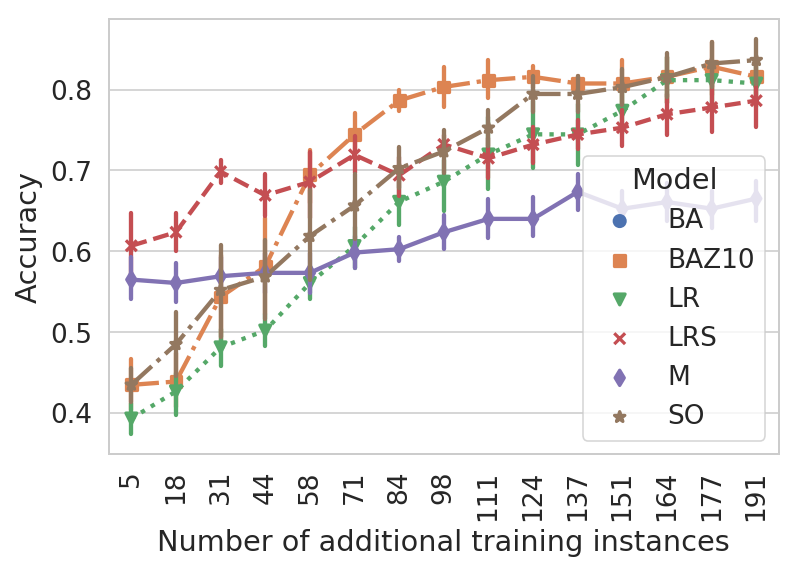

In [58]:
scores_df = []
for sk, sv in scores.items():
    for s, d in zip(sv, additional_data):
        for i, si in enumerate(s):
            scores_df.append({
                'x': d,
                'score': si,
                'trial': i,
                'model': sk
            })
scores_df = pd.DataFrame(scores_df)

fig, ax = plt.subplots()
sns.pointplot(x='x', y='score', hue='model', data=scores_df, hue_order=np.sort(scores_df.model.unique().tolist() + ['BA']), markers=markers, linestyles=linestyles, ci=68)
ax.set_xlabel('Number of additional training instances')
ax.set_ylabel('Accuracy')
ax.legend(title='Model')
xlabels = [_.get_text() for _ in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=90)
fig.savefig('canadian_parliament_main_expt.pdf', bbox_inches='tight')

In [56]:
from sklearn.feature_selection import chi2

Xstack = sparse.vstack([X[36], X[39]])
Ystack = np.hstack([Y[36], Y[39]])
Cstack = np.hstack([C[36], C[39]])
x2, pval = chi2(Xstack, Ystack)
x2_sort_idx = np.argsort(x2)

for ft_idx in x2_sort_idx[::-1][:10]:
    vals = tuple([vec[ft_idx] for vec in [feature_names, x2, pval]])
    print("%20s\t%5.3f\t%5.3f" % vals)

NameError: name 'X' is not defined

### Common top features

For this experiment, we fit a logistic regression model on the data from each parliament. We then look at the N features with the largest coefficient in this model for each class (i.e. 'Liberal' and 'Conservative'). This gives us the N most predictive features for each party in every parliament.

We then compute a common features score to see how close the predictive vocabularies are for two different parties in two parliaments. Let's note $C_{ijn}$ the coefficients vector for party $i$ in parliament $j$ for the top $n$ features and $F_{ijn}$ the corresponding features vector, then we compute the common features score $S$ as follows:

$$
S(i,j,r,s,n) = \sum_{v,w,F_{ijn}[v]=F_{rsn}[w]}{C_{ijn}[v] + C_{rsn}[w]}
$$

In another words the common features score is the sum of the coefficients for the features that appear in the two parliament/party pairs we want to compare.

In [653]:
def get_top_features(clf, p, feature_names, labels, n=10):
    clf.fit(X[p],Y[p])
    top_n_idx = {}
    label2index = {}
    top_features_dict = {}
    if len(labels) == 2:
        label2index[labels[0]] = 0
        label2index[labels[1]] = 0
        sorted_idx = np.argsort(clf.coef_[0])
        top_n_idx[labels[0]] = sorted_idx[::-1][:n]
        top_n_idx[labels[1]] = sorted_idx[:n]
    else:
        for i, l in enumerate(labels):
            label2index[l] = i
            top_n_idx[l] = np.argsort(clf.coef_[i])[::-1][:n]
    for label, top_n in top_n_idx.items():
        top_features = feature_names[top_n]
        top_coef = clf.coef_[label2index[label]][top_n]
        top_features_dict[label] = list(zip(top_features, top_coef))
    return top_features_dict        
    


In [656]:
top_features = {}
for parl in parl_number:
    top_features[parl] = get_top_features(svc_clf, parl, feature_names, labels, n=100)


In [817]:
labels = le.classes_
feature_names = np.array(vec.get_feature_names())

def common_features_coef_ratio(parl1, party1, parl2, party2):
    top_dict1 = get_top_features(svc_clf, parl1, feature_names, labels, n=n)
    fts_p1, coef_p1 = zip(*top_dict1[party1])
    fts_p1 = np.array(fts_p1)
    coef_p1 = np.abs(coef_p1)

    top_dict2 = get_top_features(svc_clf, parl2, feature_names, labels, n=n)
    fts_p2, coef_p2 = zip(*top_dict2[party2])
    fts_p2 = np.array(fts_p2)
    coef_p2 = np.abs(coef_p2)
    
    common_fts_idx = [(i, int(np.where(fts_p2 == fts_p1[i])[0])) for i in range(fts_p1.shape[0]) if fts_p1[i] in fts_p2]
    acc = 0
    print("Common features between %d%s and %d%s:" % (parl1, party1[0], parl2, party2[0]))
    if not common_fts_idx:
        print("\tNone")
    else:
        header = "\t  %-20s\t%s\t%s\t%s\t%s\t%s\t%s" % ('feature name', 'idx1', 'coef1', 'idx2', 'coef2', 'dt idx', 'dt coef')
        print(header)
        print('\t\t%s' % ('-'*len(header)))
    sum_coefs = np.sum(coef_p1) + np.sum(coef_p2)
    for idx1, idx2 in common_fts_idx:
        acc += coef_p1[idx1]
        acc += coef_p2[idx2]
        print("\t- %-20s\t%d\t%.3f\t%d\t%.3f\t%d\t%.3f" % (fts_p1[idx1], idx1, coef_p1[idx1], idx2, coef_p2[idx2],
                                                     np.abs(idx1-idx2), np.abs(coef_p1[idx1]-coef_p2[idx2])))
    return acc/sum_coefs

In [818]:
n = 50
common_features_matrix = np.zeros((6,6))
for p1_idx, parl1 in enumerate(parl_number):
    for p2_idx, parl2 in enumerate(parl_number):
        for pa1_idx, party1 in enumerate(le.classes_):
            for pa2_idx, party2 in enumerate(le.classes_):
                r = p1_idx*2 + pa1_idx
                c = p2_idx*2 + pa2_idx
                if common_features_matrix[c,r] == 0 and c != r:
                    common_features_matrix[r,c] = common_features_coef_ratio(parl1, party1, parl2, party2)
# common_features_matrix /= np.sum(common_features_matrix)
axis_names = ["%d%s" % (parl, party[0]) for parl in parl_number for party in le.classes_]

Common features between 36C and 36L:
	None
Common features between 36L and 36C:
	None
Common features between 36C and 39C:
	  feature name        	idx1	coef1	idx2	coef2	dt idx	dt coef
		------------------------------------------------------------
	- ontario             	12	0.471	5	0.667	7	0.196
	- deficit             	14	0.452	24	0.433	10	0.019
	- nation              	45	0.300	26	0.422	19	0.123
Common features between 36C and 39L:
	  feature name        	idx1	coef1	idx2	coef2	dt idx	dt coef
		------------------------------------------------------------
	- report              	1	0.786	6	0.653	5	0.133
	- standing            	2	0.765	9	0.647	7	0.118
	- languages           	9	0.533	7	0.652	2	0.119
	- proud               	16	0.450	21	0.496	5	0.046
	- benefits            	25	0.364	28	0.405	3	0.040
	- bloc                	26	0.363	4	0.724	22	0.361
	- provides            	29	0.362	18	0.503	11	0.141
	- benefit             	40	0.314	20	0.497	20	0.183
	- committed           	41	0.311	2	0.784	39	0

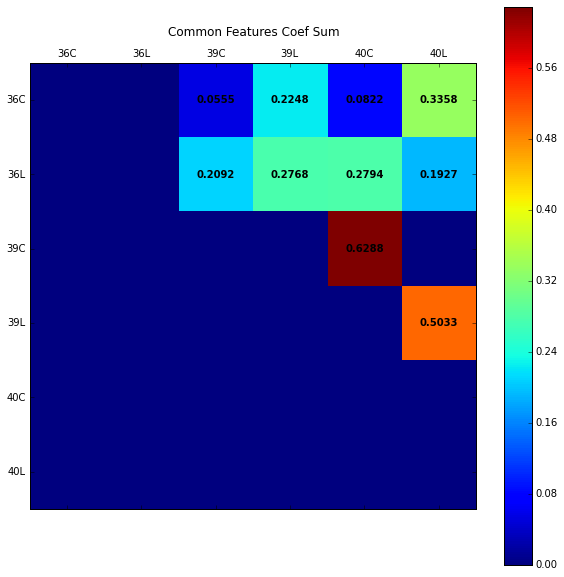

In [785]:
plot_matrix(common_features_matrix, 'Common Features Coef Sum',axis_names, axis_names, figsize=(10, 10),
            xlabel = '', ylabel = '')